# Time series spectral analysis

In [26]:
import itertools
import warnings

import numpy as np
import pandas as pd
import scipy.signal
import scipy.special
import scipy.stats as st
import bebi103
import matplotlib.pyplot as plt
import corner
%config InlineBackend.figure_formats = {'png', 'retina'}

import seaborn as sns
rc = {'lines.linewidth': 2, 'axes.labelsize': 18, 'axes.titlesize': 18, 'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
from bokeh.plotting import figure
#import bokeh.charts.utils
import bokeh.io
import bokeh.models
import bokeh.palettes
import bokeh.plotting
bokeh.io.output_notebook()
warnings.simplefilter(action='ignore', category=FutureWarning)

Loading BokehJS ...

In [7]:
df = pd.read_csv('D:/data/csv/retina_trace.csv', comment='#', names=['t (ms)', 'V (µV)'])
df.head()

,t (ms),V (µV)
0,303.96,-18.44
1,304.00,0.94
2,304.04,-6.35
3,304.08,-14.38
4,304.12,-0.52


In [8]:
# Start at zero
df['t (ms)'] -= df['t (ms)'].min()
# Convert to seconds
df['t (ms)'] /= 1000
df = df.rename(columns={'t (ms)': 't (s)'})

### Data analysis

In [10]:
print('n samples =', df.shape[0])
print('max time  =', df['t (s)'].max(), 's') 

n samples = 2682401
max time  = 107.296 s


In [11]:
inter_sample_time = df['t (s)'][1] - df['t (s)'][0]
print('inter sample time =', inter_sample_time, 's')

# Check to make sure they are all the same
print('All the same?:', np.allclose(np.diff(df['t (s)']), inter_sample_time))

inter sample time = 4.000000000002046e-05 s
All the same?: True


### Exploring the trace

In [27]:
p= figure(title='Trace', x_axis_label= 't (s)',y_axis_label= 'V (µV)')
p.line(df.loc[10000:30000,:]['t (s)'], df.loc[10000:30000,:]['V (µV)'], color='slateblue')
bokeh.io.show(p)

In [30]:
inds = (0.675 < df['t (s)']) & (df['t (s)'] < 0.69)
p= figure(title='Trace', x_axis_label= 't (s)',y_axis_label= 'V (µV)')
p.line(df.loc[inds,:]['t (s)'], df.loc[inds,:]['V (µV)'], color='slateblue')
bokeh.io.show(p)

### Frequency domain

In [34]:
sampling_freq =  1 / inter_sample_time

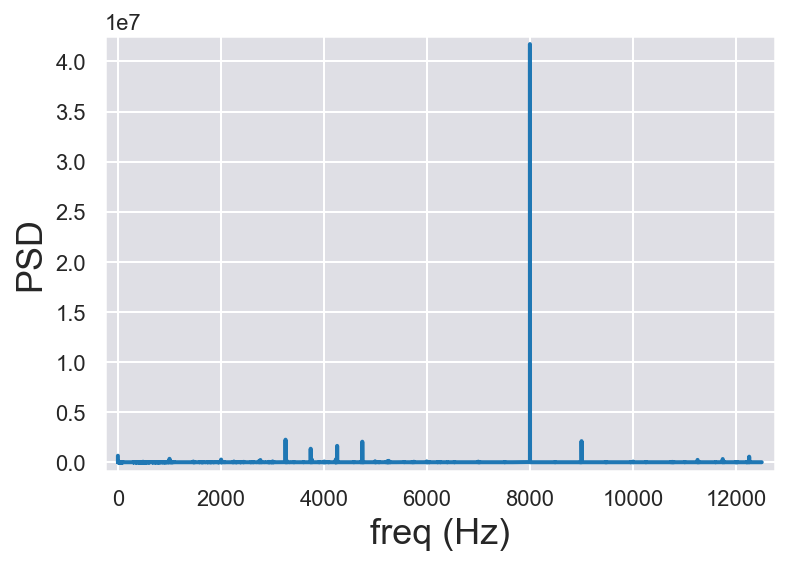

In [35]:
# Determine frequencies
f = np.fft.fftfreq(len(df)) * sampling_freq

# Compute power spectral density
psd = np.abs(np.fft.fft(df['V (µV)'].values))**2 / len(df)

# Make plot
plt.plot(f[f>=0], psd[f>=0])
plt.xlabel('freq (Hz)')
plt.ylabel('PSD')
plt.margins(0.02)

In [36]:
# Compute Nyquist frequency
nyquist_freq = sampling_freq / 2

# Design a butterworth filter
b, a = scipy.signal.butter(3, 100 / nyquist_freq, btype='high')

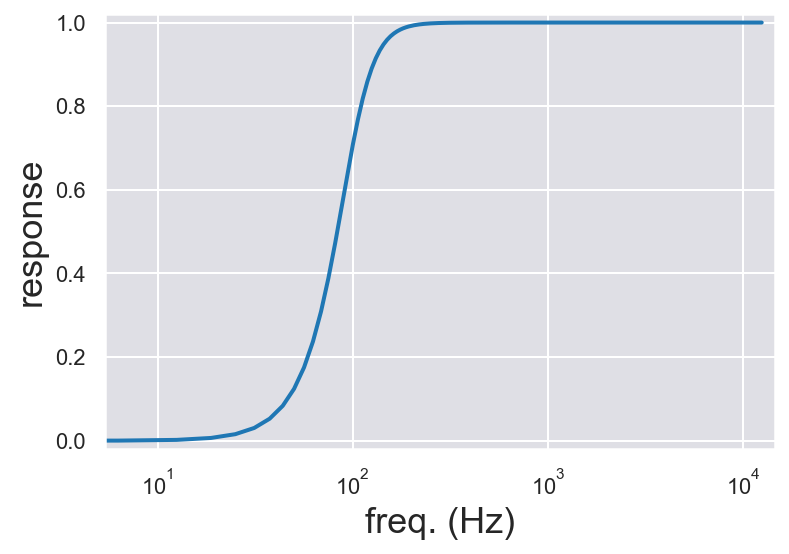

In [37]:
# Get frequency response curve
w, h = scipy.signal.freqz(b, a, worN=2000)

# Make plot
plt.semilogx((nyquist_freq / np.pi) * w, abs(h))
plt.xlabel('freq. (Hz)')
plt.ylabel('response')
plt.margins(0.02)

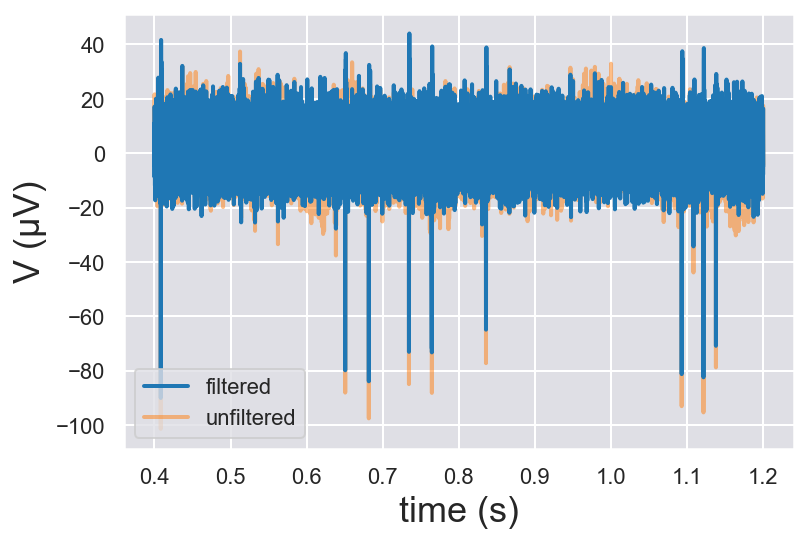

In [38]:
# Filter data
df['V filtered (µV)'] = scipy.signal.lfilter(b, a, df['V (µV)'])

# Plot the result, overlaying filtered and unfiltered
plt.plot(df['t (s)'][10000:30000], df['V filtered (µV)'][10000:30000], '-', 
         zorder=2, label='filtered')
plt.plot(df['t (s)'][10000:30000], df['V (µV)'][10000:30000], '-', 
         alpha=0.5, zorder=1, label='unfiltered')
plt.xlabel('time (s)')
plt.ylabel('V (µV)')
plt.legend(loc='lower left')

### Credits & Links

http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2015/tutorials/t7a_time_series.html